In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import unicodedata
import re #para trabajar con expresiones regulares

#web scrapping libraries
import requests
from bs4 import BeautifulSoup

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **De la Web al Análisis: Scraping + EDA de las Convocatorias Docentes en Universidades de España**
________________

### Para el análisis se aplicaron dos fases principales:

### **1. Web Scraping:**

#### * Se extrajo la información desde [fuente o página web específica].
#### * Se emplearon librerías como requests y BeautifulSoup en Python para recolectar los datos de manera estructurada.
#### * Los datos fueron almacenados en un DataFrame para su posterior procesamiento.


### **2. Exploratory Data Analysis (EDA):**

#### * Se realizó limpieza de datos y de texto.

#### * Se aplicaron transformaciones (extracción de año y mes y generación de nuevas columnas).
 
#### * Se utilizaron visualizaciones para identificar patrones y tendencias.

## **Sección 1: Web Scrapping** 

In [2]:
#Web scrapping
url = 'https://serviciopdi.ugr.es/contratado/concursopublico/otrasuniversidades/index.html'
page = requests.get(url)
print(f"Status code: {page.status_code}")

Status code: 200


In [3]:
## Analizar el HTML con BeautifulSoup
soup = BeautifulSoup(page.content,'html.parser')

#Extraer tabla HTML
tablas_pages = pd.read_html(str(soup), header = 0)
df = tablas_pages[0]
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/html.py:661: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(udoc, features="html5lib", from_encoding=from_encoding)


,Categoría,Universidad,Enlace para obtener más Información,Fecha de comunicación
0,Profesor Asociado y Profesor Ayudante Doctor,Universidad de la Coruña,Convocatoria 1794:Más información,30-07-2025
1,Profesor Asociado,Universidad de León,Convocatoria 1795:Más información,30-07-2025
2,Profesor Asociado y Profesor Ayudante Doctor,Universidad de León,Convocatoria 1793:Más información,29-07-2025
3,Profesor Asociado,Universidad de León,Convocatoria 1791:Más información,23-07-2025
4,Profesor Asociado y Profesor Ayudante Doctor,Universidad Autónoma de Madrid,Convocatoria 1792:Más información,23-07-2025


## **Sección 2: Análisis Exploratorio de Datos** 

In [4]:
data = df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Categoría                            1782 non-null   object
 1   Universidad                          1782 non-null   object
 2   Enlace para obtener más Información  1782 non-null   object
 3   Fecha  de comunicación               1782 non-null   object
dtypes: object(4)
memory usage: 55.8+ KB


In [5]:
#drop irrelevant columns 
data = data.drop(columns=['Enlace para obtener más Información'])

#rename the columns
data = data.rename(columns = {'Categoría':'Categoria', 'Universidad':'Universidad', 'Fecha  de comunicación':'Fecha'})

data.head()

,Categoria,Universidad,Fecha
0,Profesor Asociado y Profesor Ayudante Doctor,Universidad de la Coruña,30-07-2025
1,Profesor Asociado,Universidad de León,30-07-2025
2,Profesor Asociado y Profesor Ayudante Doctor,Universidad de León,29-07-2025
3,Profesor Asociado,Universidad de León,23-07-2025
4,Profesor Asociado y Profesor Ayudante Doctor,Universidad Autónoma de Madrid,23-07-2025


In [6]:
# Convertir a tipo datetime
data["Fecha"] = pd.to_datetime(data["Fecha"])

# Extraer año y mes
data["Año"] = data["Fecha"].dt.year
data["Mes"] = data["Fecha"].dt.month

data.head()

/tmp/ipykernel_36/1873817829.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["Fecha"] = pd.to_datetime(data["Fecha"])


,Categoria,Universidad,Fecha,Año,Mes
0,Profesor Asociado y Profesor Ayudante Doctor,Universidad de la Coruña,2025-07-30,2025,7
1,Profesor Asociado,Universidad de León,2025-07-30,2025,7
2,Profesor Asociado y Profesor Ayudante Doctor,Universidad de León,2025-07-29,2025,7
3,Profesor Asociado,Universidad de León,2025-07-23,2025,7
4,Profesor Asociado y Profesor Ayudante Doctor,Universidad Autónoma de Madrid,2025-07-23,2025,7


In [7]:
# Separar por " y "
grados = data['Categoria'].str.split(' y ', expand=True)

# Extraer "Profesor" y los grados
data['Tipo'] = 'Profesor'
data['Grado1'] = grados[0].str.replace('Profesor ', '', regex=False)
data['Grado2'] = grados[1].str.replace('Profesor ', '', regex=False)

#drop column 'Categoria'
data = data.drop(columns=['Categoria'])

print(data.shape)

data.head()

(1782, 7)


,Universidad,Fecha,Año,Mes,Tipo,Grado1,Grado2
0,Universidad de la Coruña,2025-07-30,2025,7,Profesor,Asociado,Ayudante Doctor
1,Universidad de León,2025-07-30,2025,7,Profesor,Asociado,None
2,Universidad de León,2025-07-29,2025,7,Profesor,Asociado,Ayudante Doctor
3,Universidad de León,2025-07-23,2025,7,Profesor,Asociado,None
4,Universidad Autónoma de Madrid,2025-07-23,2025,7,Profesor,Asociado,Ayudante Doctor


In [8]:
### Limpieza de la columna 'Universidad'
#### 1. Convertir todo a mayúsculas.
#### 2. Eliminar tildes.
#### 3. Reemplazar guiones por espacios.
#### 4. Reemplazar todas las variantes de “Univ.” o “Universidad-de-la” por “UNIVERSIDAD”.
#### 5. Elimine artículos innecesarios como “DE LA”, “DEL” y “DE”
#### 6. Dejar solo un espacio entre palabras.


# Función de limpieza completa
def limpiar_universidad(texto):
    # Convertir a mayúsculas
    texto = texto.upper()
    # Reemplazar guiones por espacios
    texto = texto.replace('-', ' ')
    # Eliminar tildes
    texto = ''.join(
        c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn'
    )
    # Reemplazar variantes de Univ. por UNIVERSIDAD
    texto = re.sub(r'\bUNIV\.?\b', 'UNIVERSIDAD', texto)
    # Eliminar artículos innecesarios
    #texto = re.sub(r'\bDE LA\b', '', texto)
    #texto = re.sub(r'\bDEL\b', '', texto)
    #texto = re.sub(r'\bDE\b', '', texto)
    # Reemplazar múltiples espacios por uno solo
    texto = re.sub(r'\s+', ' ', texto)
    # Quitar espacios al inicio y final
    texto = texto.strip()
    return texto

# Aplicar limpieza
data['Universidad'] = data['Universidad'].apply(limpiar_universidad)

# Diccionario de corrección manual (ejemplo)
correcciones = {
    'UNIVERSIDAD CORUÑA': 'UNIVERSIDAD DE LA CORUNA',
    'UNIVERSIDAD JAIME I': 'UNIVERSIDAD JAIME I DE CASTELLON',
    'UNIVERSIDAD MIGUEL HERNANDEZ DE ELCHE': 'UNIVERSIDAD MIGUEL HERNANDEZ',
    'UNIVERSIDA DE SALAMANCA': 'UNIVERSIDAD DE SALAMANCA',
    'UNIVERSIDAD PABLO DE OLAVIDE DE SEVILLA': 'UNIVERSIDAD PABLO DE OLAVIDE',
    'UNIVERSIDAD PABLO OLAVIDE': 'UNIVERSIDAD PABLO DE OLAVIDE',
    'UNIVERSIDAD CARLOS III': 'UNIVERSIDAD CARLOS III DE MADRID',
    'UNIVERSIDAD DE SALAMANA': 'UNIVERSIDAD DE SALAMANCA',
    'UNIVERSIDAD DE ALCALA': 'UNIVERSIDAD DE ALCALA DE HENARES',
    'UNIVERSIDAD DE VALLADOLIDA': 'UNIVERSIDAD DE VALLADOLID',
    'UNIVERSIDAD DE SANTIAGO': 'UNIVERSIDAD DE SANTIAGO DE COMPOSTELA',
    'UNIVERSIDAD VALENCIA': 'UNIVERSIDAD DE VALENCIA'
    # Agrega todas las variantes que quieras corregir
}

data['Universidad'] = data['Universidad'].replace(correcciones)

print(data.shape)

data.head()

(1782, 7)


,Universidad,Fecha,Año,Mes,Tipo,Grado1,Grado2
0,UNIVERSIDAD DE LA CORUNA,2025-07-30,2025,7,Profesor,Asociado,Ayudante Doctor
1,UNIVERSIDAD DE LEON,2025-07-30,2025,7,Profesor,Asociado,None
2,UNIVERSIDAD DE LEON,2025-07-29,2025,7,Profesor,Asociado,Ayudante Doctor
3,UNIVERSIDAD DE LEON,2025-07-23,2025,7,Profesor,Asociado,None
4,UNIVERSIDAD AUTONOMA DE MADRID,2025-07-23,2025,7,Profesor,Asociado,Ayudante Doctor


In [9]:
# Conteo de convocatorias por universidad
conteo = data['Universidad'].value_counts().reset_index()
conteo.columns = ['Universidad', 'Convocatorias']

conteo

,Universidad,Convocatorias
0,UNIVERSIDAD DE LEON,184
1,UNIVERSIDAD AUTONOMA DE MADRID,139
2,UNIVERSIDAD DE MURCIA,138
3,UNIVERSIDAD DE SALAMANCA,130
4,UNIVERSIDAD JAIME I DE CASTELLON,124
5,UNIVERSIDAD DE ALICANTE,105
6,UNIVERSIDAD DE LA CORUNA,79
7,UNIVERSIDAD DE VALLADOLID,76
8,UNIVERSIDAD MIGUEL HERNANDEZ,69
9,UNIVERSIDAD NACIONAL DE EDUCACION A DISTANCIA,53


## **Sección 3: Geolocalización de Universidades de España** 

In [ ]:
# -------------------------------
# Sección: Geolocalización de universidades
# -------------------------------

from geopy.geocoders import Nominatim
import time

# Inicializar geolocalizador
geolocator = Nominatim(user_agent="geoapiSpain")

# Función para obtener latitud, longitud y dirección
def obtener_ubicacion(nombre):
    try:
        location = geolocator.geocode(nombre + ", España")  # Asegura que busque en España
        time.sleep(1)  # Espera 1 segundo para no sobrecargar el servicio
        if location:
            return pd.Series([location.latitude, location.longitude, location.address])
        else:
            return pd.Series([None, None, None])
    except:
        return pd.Series([None, None, None])

# Aplicar función
data[["latitud", "longitud", "direccion_completa"]] = data["Universidad"].apply(obtener_ubicacion)

# Extraer provincia si está en la dirección completa
data["Provincia"] = data["direccion_completa"].apply(lambda x: x.split(",")[1].strip() if pd.notnull(x) else None)

data.head()

## **Sección 4: Visualización de Datos** 

<Figure size 1000x600 with 0 Axes>

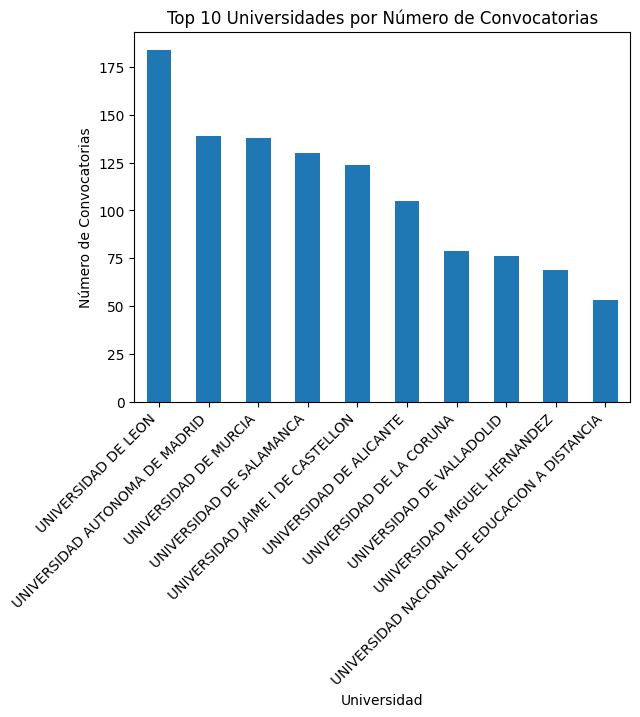

In [10]:
# Conteo de convocatorias por universidad
conteo = data['Universidad'].value_counts().reset_index()
conteo.columns = ['Universidad', 'Convocatorias']
top10 = conteo.head(10)


plt.figure(figsize=(10,6))
top10.plot(kind='bar', x='Universidad', y='Convocatorias', legend=False)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Número de Convocatorias")
plt.title("Top 10 Universidades por Número de Convocatorias")
plt.show()

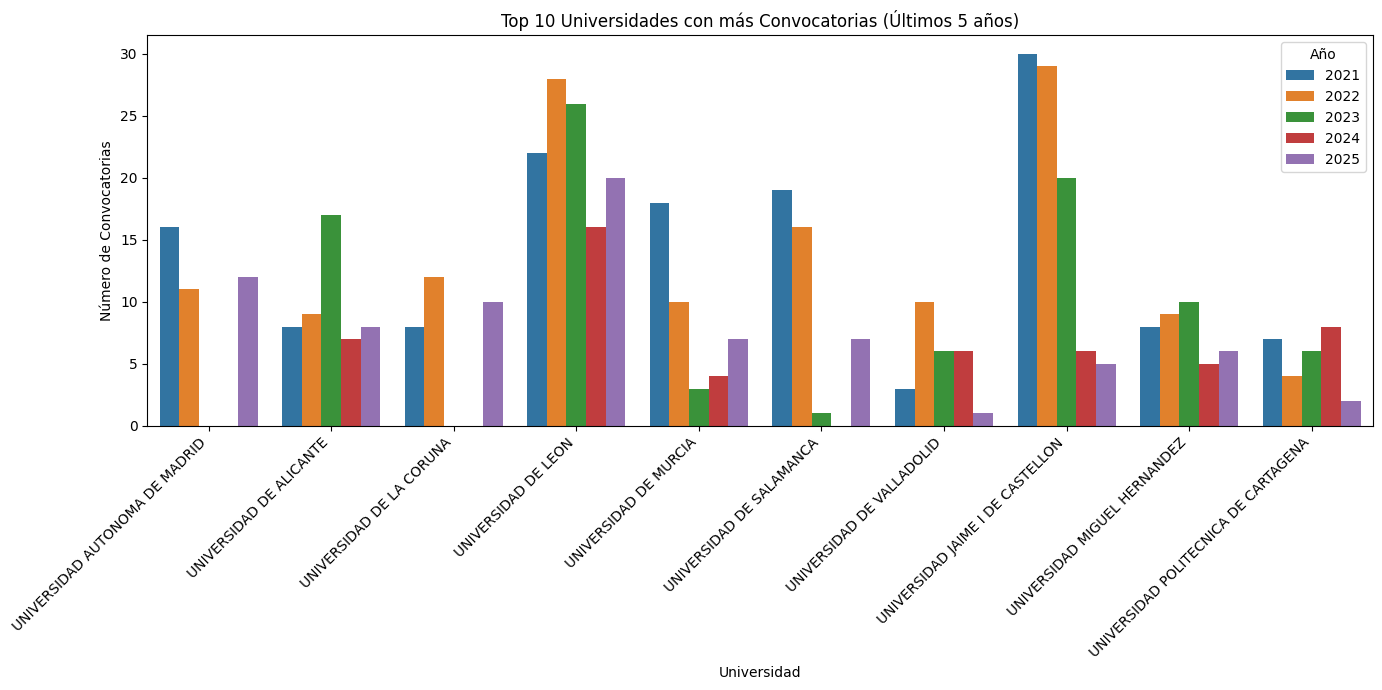

In [11]:
# Últimos 5 años
ultimos_5 = data['Año'].max() - 4
df_5 = data[data['Año'] >= ultimos_5]

# Top 10 universidades en los últimos 5 años
top10_unis = df_5['Universidad'].value_counts().head(10).index

# Filtrar solo esas universidades
df_top10 = df_5[df_5['Universidad'].isin(top10_unis)]

# Agrupar por universidad y año
conteo = df_top10.groupby(['Universidad', 'Año']).size().reset_index(name='Convocatorias')

# Gráfico de barras
plt.figure(figsize=(14,7))
sns.barplot(data=conteo, x='Universidad', y='Convocatorias', hue='Año')

plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Universidades con más Convocatorias (Últimos 5 años)")
plt.ylabel("Número de Convocatorias")
plt.xlabel("Universidad")
plt.legend(title='Año')
plt.tight_layout()
plt.show()

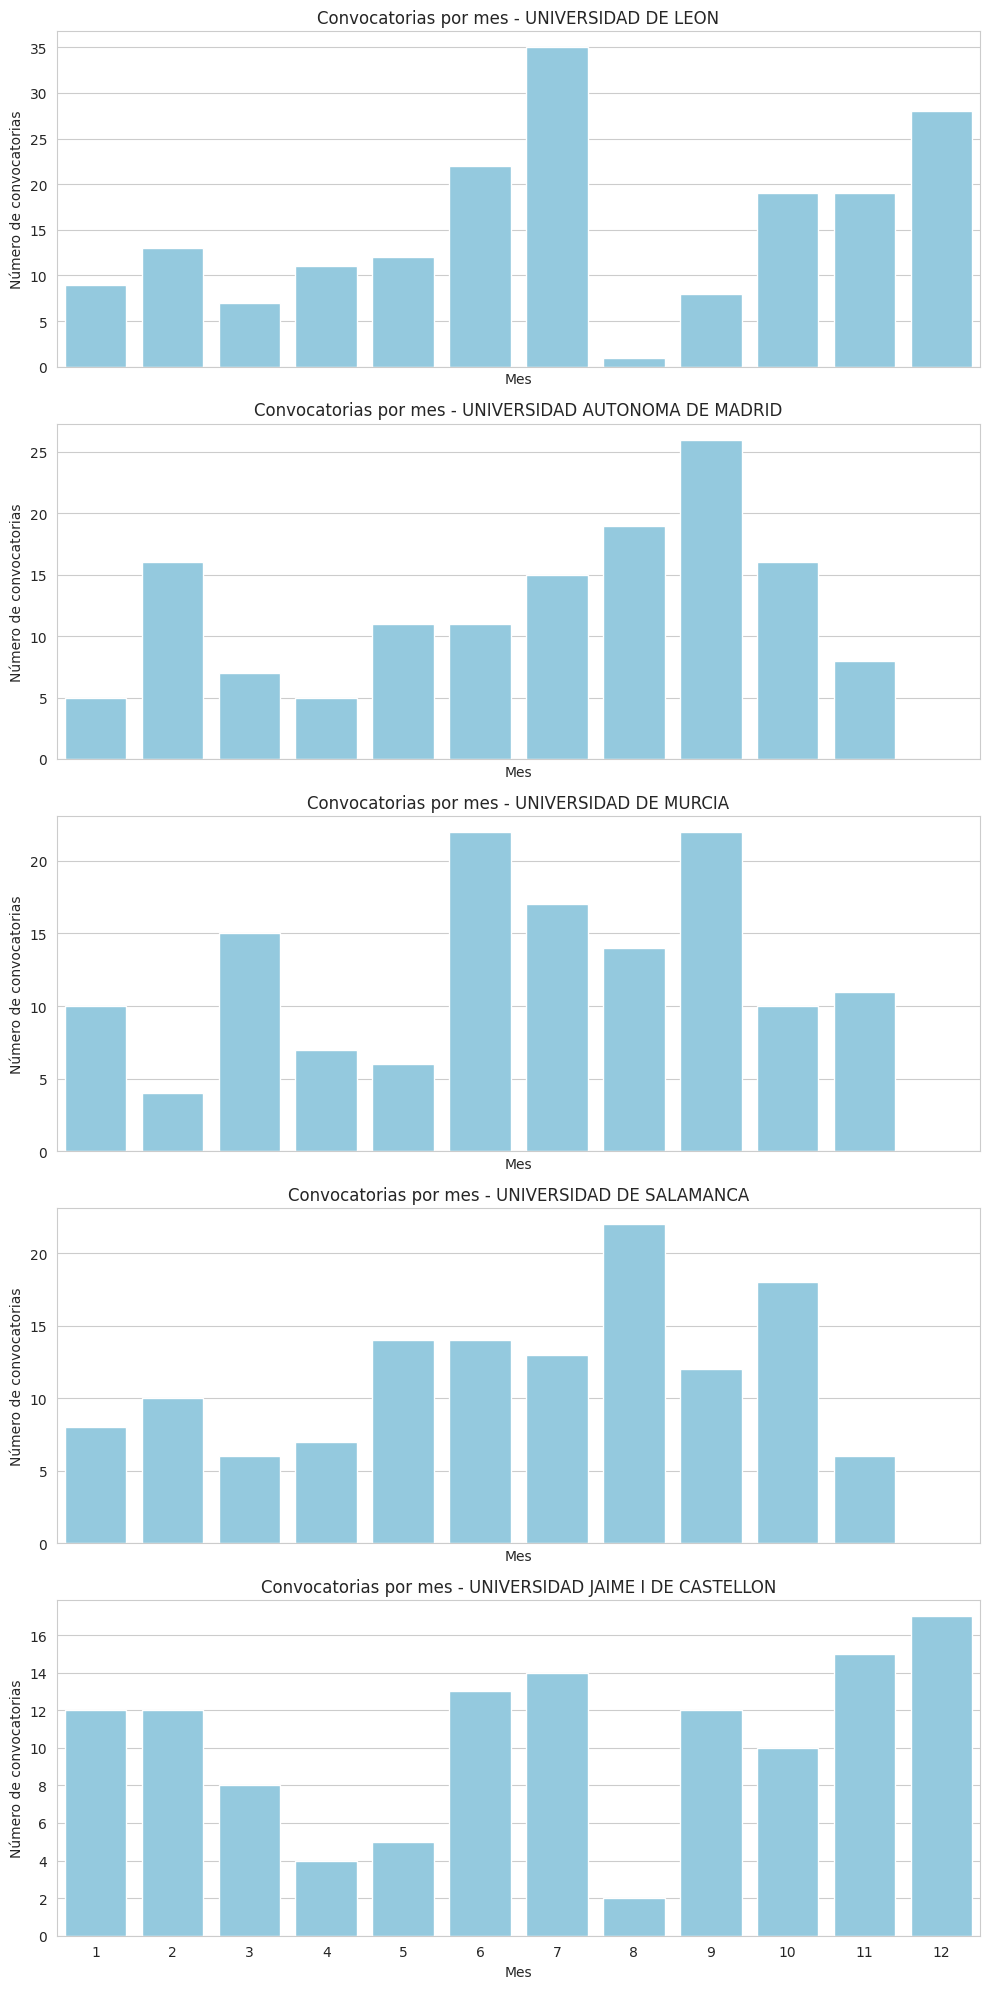

In [16]:
# Contar convocatorias totales por universidad
top_universities = data['Universidad'].value_counts().head(5).index

# Filtrar solo las 5 universidades principales
data_top5 = data[data['Universidad'].isin(top_universities)]

# Contar convocatorias por mes para cada universidad
convocatorias = data_top5.groupby(['Universidad', 'Mes']).size().reset_index(name='Count')

# Crear un gráfico por cada universidad
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20), sharex=True)

for i, university in enumerate(top_universities):
    sns.barplot(
        data=convocatorias[convocatorias['Universidad'] == university],
        x='Mes', y='Count', ax=axes[i], color='skyblue'
    )
    axes[i].set_title(f'Convocatorias por mes - {university}')
    axes[i].set_ylabel('Número de convocatorias')
    axes[i].set_xlabel('Mes')

plt.tight_layout()
plt.show()